In [1]:
import os
import random
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
from PIL import Image

## Dataset

In [2]:
class TripletDataset:

    def __init__(self,filepath,train,transform=None):
        
        if train:
            self.data = np.loadtxt(filepath + 'peopleDevTrain.txt' ,skiprows=1, delimiter='\t', dtype='str')
        else:
            self.data = np.loadtxt(filepath + 'peopleDevTest.txt' ,skiprows=1, delimiter='\t', dtype='str')

        #Transformation for single image
        self.root_path = os.path.join(filepath,'lfw')
        self.ids = np.arange(self.data.shape[0])
        self.transform = transform

    def __len__(self):

        return self.data.shape[0]

    def gen_anchor(self,image):
        
        compose = transforms.Compose([transforms.ColorJitter(brightness=.5, contrast=0.4, saturation= 0.5, hue= 0.1),
                                      transforms.RandomPerspective(distortion_scale=0.2,p=1)])
        transformed_img = compose(image)

        return transformed_img
        

    def __getitem__(self,idx):

        person_name = self.data[idx,0]
        num_images = int(self.data[idx,1])

        error = 10000
        if num_images == 1:
            
            anchor = person_name + '_' + str(num_images).zfill(4) + '.jpg'
            anchor_image = Image.open(os.path.join(self.root_path,person_name,anchor))

            positive_img = self.gen_anchor(anchor_image)


        else:
            
            positive_samples = np.random.randint(1,num_images,size=2)

            anchor = person_name + '_' + str(positive_samples[0]).zfill(4) + '.jpg'
            anchor_image = Image.open(os.path.join(self.root_path,person_name,anchor))
            
            positive = person_name + '_' + str(positive_samples[1]).zfill(4) + '.jpg'
            positive_img = Image.open(os.path.join(self.root_path,person_name,positive))

        
        neg_idx = np.random.choice(self.ids[np.where(self.ids != idx)])
        negative_name = self.data[neg_idx,0]
        negative_number = int(self.data[neg_idx,1])
    
        if negative_number > 1:
            negative_number = np.random.randint(1,negative_number+1)

        negative = negative_name + '_' + str(negative_number).zfill(4) + '.jpg'
        negative_img = Image.open(os.path.join(self.root_path,negative_name, negative))

        if self.transform:
            anchor_image = self.transform(anchor_image)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return (anchor_image,positive_img,negative_img)

In [3]:
transform = transforms.Compose([transforms.Resize(size=(64,64)),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = TripletDataset('/home/dhagash/MS-GE-03/CudaVision/assignment-8/data/',True,transform=transform)
test_dataset = TripletDataset('/home/dhagash/MS-GE-03/CudaVision/assignment-8/data/',False,transform=transform)

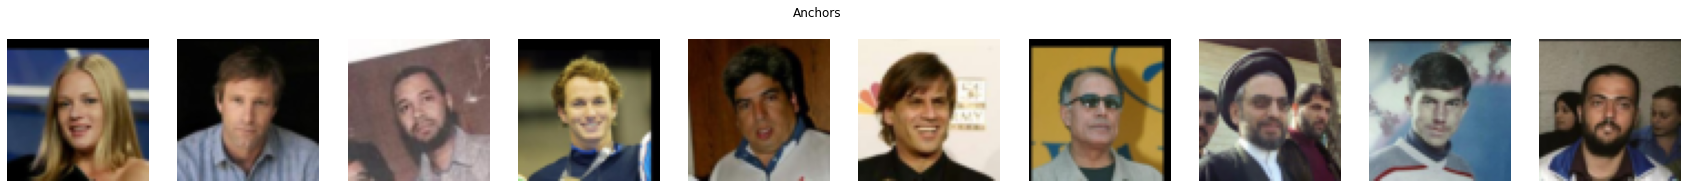

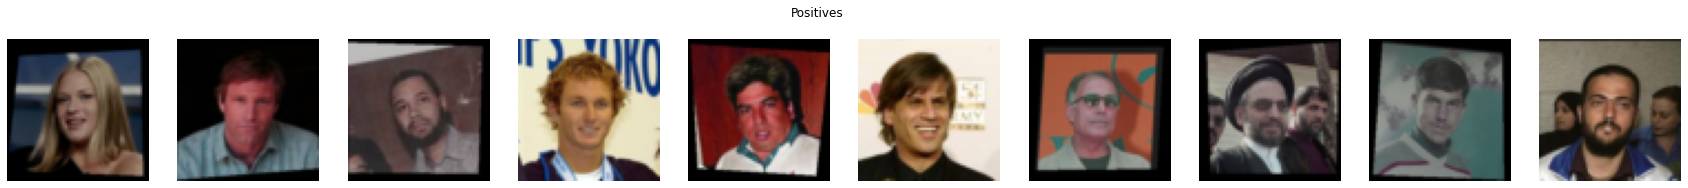

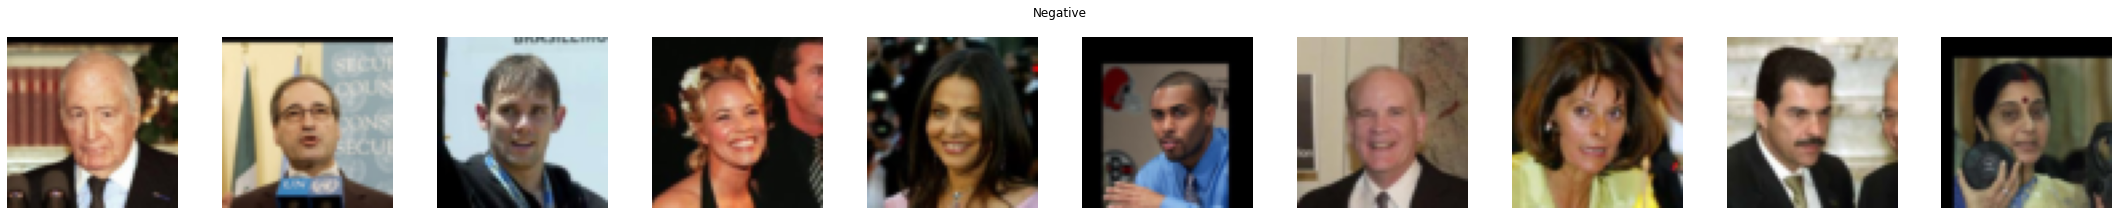

In [4]:
fig_anchors, anchors = plt.subplots(1, 10, figsize=(30,3))
fig_pos, positives = plt.subplots(1, 10, figsize=(30,3))
fig_neg, negatives = plt.subplots(1, 10, figsize=(30,3))
for i in range(10):
    (anchor, positive, negative) = train_dataset[i]
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    anchor = anchor.permute(1,2,0).numpy() * std + mean
    positive = positive.permute(1,2,0).numpy() * std + mean
    negative = negative.permute(1,2,0).numpy() * std + mean
    anchors[i].imshow(anchor)
    anchors[i].axis("off")
    positives[i].imshow(positive)
    positives[i].axis("off")
    negatives[i].imshow(negative)
    negatives[i].axis("off")
fig_anchors.suptitle("Anchors")
fig_pos.suptitle("Positives")
fig_neg.suptitle("Negative")
plt.tight_layout()

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

## Utils

In [6]:
# utils

def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f


def save_model(model, optimizer, epoch, stats):
    """ Saving model checkpoint """
    
    if(not os.path.exists("checkpoints")):
        os.makedirs("checkpoints")
    savepath = f"checkpoints/checkpoint_epoch_{epoch}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    
    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """
    
    checkpoint = torch.load(savepath, map_location="cpu")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]
    
    return model, optimizer, epoch, stats


def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

def visualize_progress(train_loss, val_loss, start=0):
    """ Visualizing loss and accuracy """
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(24,5)

    smooth_train = smooth(train_loss, 31)
    ax[0].plot(train_loss, c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[0].plot(smooth_train, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[0].legend(loc="best")
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("CE Loss")
    ax[0].set_yscale("linear")
    ax[0].set_title("Training Progress (linear)")
    
    ax[1].plot(train_loss, c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[1].plot(smooth_train, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[1].legend(loc="best")
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("CE Loss")
    ax[1].set_yscale("log")
    ax[1].set_title("Training Progress (log)")

    smooth_val = smooth(val_loss, 31)
    N_ITERS = len(val_loss)
    ax[2].plot(np.arange(start, N_ITERS)+start, val_loss[start:], c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[2].plot(np.arange(start, N_ITERS)+start, smooth_val[start:], c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[2].legend(loc="best")
    ax[2].set_xlabel("Iteration")
    ax[2].set_ylabel("CE Loss")
    ax[2].set_yscale("log")
    ax[2].set_title(f"Valid Progress")

    return

def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    COLORS = ['r', 'b', 'g', 'y', 'purple', 'orange', 'k', 'brown', 'grey',
              'c', "gold", "fuchsia", "lime", "darkred", "tomato", "navy"]
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(12,6))
    
    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)

        ax.scatter(points[idx, 0], points[idx, 1], label=legend[int(l)], c=COLORS[i])
    ax.legend(loc="best")

## Model

In [7]:
class NormLayer(nn.Module):
    """ Layer that computer embedding normalization """
    def __init__(self, l=2):
        """ Layer initializer """
        assert l in [1,2]
        super().__init__()
        self.l = l
        return
    
    def forward(self, x):
        """ Normalizing embeddings x. The shape of x is (B,D) """
        x_normalized = x / torch.norm(x, p=self.l, dim=-1, keepdim=True)
        return x_normalized

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
  
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
    elif classname.find('Linear') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)

class SiameseNetwork(nn.Module):

    def __init__(self, pretrain=False, emb_dim=128):
        
        super().__init__()
        resnet_net = torchvision.models.resnet18(pretrained=pretrain)
        modules = list(resnet_net.children())[:-1]
        self.backbone = nn.Sequential(*modules)
        
        flat_dim = list(resnet_net.children())[-1].in_features
        self.fc = nn.Linear(flat_dim,emb_dim)
        
        self.flatten = nn.Flatten()
        self.norm = NormLayer()

        return

    def forward_one(self, x):
        """ Forwarding just one sample through the model """
        x = self.backbone(x)
        x_flat = self.flatten(x)
        x_emb = self.fc(x_flat)
        x_emb_norm = self.norm(x_emb)
        return x_emb_norm
    
    def forward(self,anchor,positive,negative):
        anchor_emb = self.forward_one(anchor)
        positive_emb = self.forward_one(positive)
        negative_emb = self.forward_one(negative)
        return anchor_emb, positive_emb, negative_emb

## Training

In [9]:
class TripletLoss(nn.Module):
    """ Implementation of the triplet loss function """
    def __init__(self, margin=0.2, reduce="mean"):
        """ Module initializer """
        assert reduce in ["mean", "sum"]
        super().__init__()
        self.margin = margin
        self.reduce = reduce
        return
        
    def forward(self, anchor, positive, negative):
        """ Computing pairwise distances and loss functions """
        # L2 distances
        d_ap = (anchor - positive).pow(2).sum(dim=-1)
        d_an = (anchor - negative).pow(2).sum(dim=-1)
        
        # triplet loss function
        loss = (d_ap - d_an + self.margin)
        loss = torch.maximum(loss, torch.zeros_like(loss))
        
        # averaging or summing      
        loss = torch.mean(loss) if(self.reduce == "mean") else torch.sum(loss)
      
        return loss

In [10]:
class Trainer:
    """
    Class for training and validating a siamese model
    """
        
    def __init__(self, model, criterion, train_loader, valid_loader, n_iters=1e4,lr=3e-4):
        """ Trainer initializer """
        self.model = model
        self.criterion = criterion
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        
        self.n_iters = int(n_iters)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        
        self.train_loss = []
        self.valid_loss = []
        return
    
    @torch.no_grad()
    def valid_step(self, val_iters=100):
        """ Some validation iterations """
        self.model.eval()
        cur_losses = []
        for i, (anchors, positives, negatives) in enumerate(self.valid_loader):   
            # setting inputs to GPU
            anchors = anchors.to(self.device)
            positives = positives.to(self.device)
            negatives = negatives.to(self.device)
            
            # forward pass and triplet loss
            anchor_emb, positive_emb, negative_emb = self.model(anchors, positives, negatives)
            loss = self.criterion(anchor_emb, positive_emb, negative_emb)
            cur_losses.append(loss.item())
            
            if(i >= val_iters):
                break
    
        self.valid_loss += cur_losses
        self.model.train()
        
        return cur_losses
    
    def fit(self):
        """ Train/Validation loop """
    
        self.iter_ = 0
        progress_bar = tqdm(total=self.n_iters, initial=0)
        
        for i in range(self.n_iters):
            for (anchors, positives, negatives) in self.train_loader:     
                # setting inputs to GPU
                anchors = anchors.to(self.device)
                positives = positives.to(self.device)
                negatives = negatives.to(self.device)
                
                # forward pass and triplet loss
                anchor_emb, positive_emb, negative_emb = self.model(anchors, positives, negatives)
                loss = self.criterion(anchor_emb, positive_emb, negative_emb)
                self.train_loss.append(loss.item())
                
                # optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            
                # updating progress bar
                progress_bar.set_description(f"Train Iter {self.iter_}: Loss={round(loss.item(),5)})")
                
                # doing some validation every once in a while
                if(self.iter_ % 250 == 0):
                    cur_losses = self.valid_step()
                    print(f"Valid loss @ iteration {self.iter_}: Loss={np.mean(cur_losses)}")
                
                self.iter_ = self.iter_+1 
                if(self.iter_ >= self.n_iters):
                    break
            if(self.iter_ >= self.n_iters):
                break
        return

In [11]:
model = SiameseNetwork(pretrain=False,emb_dim=128)
model.apply(weights_init)
criterion = TripletLoss(margin=0.2)
print(f"Model has {count_model_params(model)} parameters")

Model has 11242176 parameters


In [12]:
trainer = Trainer(model=model, criterion=criterion, train_loader=train_loader, valid_loader=test_loader, n_iters=100000)

In [13]:
trainer.fit()

Train Iter 0: Loss=0.2):   0%|          | 0/100000 [00:00<?, ?it/s]

Valid loss @ iteration 0: Loss=0.20000000325617967


Train Iter 250: Loss=0.19999):   0%|          | 0/100000 [01:05<?, ?it/s]

Valid loss @ iteration 250: Loss=0.19997265272670323


Train Iter 500: Loss=0.17659):   0%|          | 0/100000 [02:09<?, ?it/s]

Valid loss @ iteration 500: Loss=0.18348354542696918


Train Iter 750: Loss=0.15722):   0%|          | 0/100000 [03:15<?, ?it/s]

Valid loss @ iteration 750: Loss=0.13776942701251418


Train Iter 1000: Loss=0.18732):   0%|          | 0/100000 [04:20<?, ?it/s]

Valid loss @ iteration 1000: Loss=0.1873629084891743


Train Iter 1250: Loss=0.07939):   0%|          | 0/100000 [05:25<?, ?it/s]

Valid loss @ iteration 1250: Loss=0.1098098189190582


Train Iter 1500: Loss=0.12581):   0%|          | 0/100000 [06:30<?, ?it/s]

Valid loss @ iteration 1500: Loss=0.11198261297411388


Train Iter 1750: Loss=0.12548):   0%|          | 0/100000 [07:35<?, ?it/s]

Valid loss @ iteration 1750: Loss=0.11387334018945694


Train Iter 2000: Loss=0.10247):   0%|          | 0/100000 [08:39<?, ?it/s]

Valid loss @ iteration 2000: Loss=0.10472745855373365


Train Iter 2250: Loss=0.06633):   0%|          | 0/100000 [09:44<?, ?it/s]

Valid loss @ iteration 2250: Loss=0.10334576983694677


Train Iter 2500: Loss=0.08912):   0%|          | 0/100000 [10:49<?, ?it/s]

Valid loss @ iteration 2500: Loss=0.10049312196120068


Train Iter 2750: Loss=0.07146):   0%|          | 0/100000 [11:53<?, ?it/s]

Valid loss @ iteration 2750: Loss=0.1024181815209212


Train Iter 3000: Loss=0.13224):   0%|          | 0/100000 [12:58<?, ?it/s]

Valid loss @ iteration 3000: Loss=0.10444574327104622


Train Iter 3250: Loss=0.10065):   0%|          | 0/100000 [14:03<?, ?it/s]

Valid loss @ iteration 3250: Loss=0.10770812313313838


Train Iter 3500: Loss=0.13343):   0%|          | 0/100000 [15:07<?, ?it/s]

Valid loss @ iteration 3500: Loss=0.09630479415257771


Train Iter 3750: Loss=0.10202):   0%|          | 0/100000 [16:13<?, ?it/s]

Valid loss @ iteration 3750: Loss=0.09936405759718683


Train Iter 4000: Loss=0.07499):   0%|          | 0/100000 [17:17<?, ?it/s]

Valid loss @ iteration 4000: Loss=0.09158171996198318


Train Iter 4250: Loss=0.11976):   0%|          | 0/100000 [18:22<?, ?it/s]

Valid loss @ iteration 4250: Loss=0.09439326408836576


Train Iter 4500: Loss=0.03145):   0%|          | 0/100000 [19:28<?, ?it/s]

Valid loss @ iteration 4500: Loss=0.08970789425075054


Train Iter 4750: Loss=0.09863):   0%|          | 0/100000 [20:32<?, ?it/s]

Valid loss @ iteration 4750: Loss=0.0893672860606953


Train Iter 5000: Loss=0.0592):   0%|          | 0/100000 [21:35<?, ?it/s] 

Valid loss @ iteration 5000: Loss=0.07259781731085645


Train Iter 5250: Loss=0.02571):   0%|          | 0/100000 [22:39<?, ?it/s]

Valid loss @ iteration 5250: Loss=0.056690952688869506


Train Iter 5500: Loss=0.03143):   0%|          | 0/100000 [23:43<?, ?it/s]

Valid loss @ iteration 5500: Loss=0.05100360083290272


Train Iter 5750: Loss=0.05827):   0%|          | 0/100000 [24:46<?, ?it/s]

Valid loss @ iteration 5750: Loss=0.05437966218839089


Train Iter 6000: Loss=0.05039):   0%|          | 0/100000 [25:51<?, ?it/s]

Valid loss @ iteration 6000: Loss=0.04716548762991334


Train Iter 6250: Loss=0.03216):   0%|          | 0/100000 [26:55<?, ?it/s]

Valid loss @ iteration 6250: Loss=0.058969713678514515


Train Iter 6500: Loss=0.05868):   0%|          | 0/100000 [27:59<?, ?it/s]

Valid loss @ iteration 6500: Loss=0.05111580366199767


Train Iter 6750: Loss=0.06194):   0%|          | 0/100000 [29:03<?, ?it/s]

Valid loss @ iteration 6750: Loss=0.05117474736093923


Train Iter 7000: Loss=0.06604):   0%|          | 0/100000 [30:07<?, ?it/s]

Valid loss @ iteration 7000: Loss=0.04510649679987519


Train Iter 7250: Loss=0.05102):   0%|          | 0/100000 [31:11<?, ?it/s]

Valid loss @ iteration 7250: Loss=0.04536233228389864


Train Iter 7500: Loss=0.04114):   0%|          | 0/100000 [32:14<?, ?it/s]

Valid loss @ iteration 7500: Loss=0.050423655141558915


Train Iter 7750: Loss=0.03004):   0%|          | 0/100000 [33:18<?, ?it/s]

Valid loss @ iteration 7750: Loss=0.055819023943816624


Train Iter 8000: Loss=0.07743):   0%|          | 0/100000 [34:21<?, ?it/s]

Valid loss @ iteration 8000: Loss=0.040802318007788725


Train Iter 8250: Loss=0.02348):   0%|          | 0/100000 [35:25<?, ?it/s]

Valid loss @ iteration 8250: Loss=0.045838804812067084


Train Iter 8500: Loss=0.00537):   0%|          | 0/100000 [36:29<?, ?it/s]

Valid loss @ iteration 8500: Loss=0.04704443082489349


Train Iter 8751: Loss=0.01104):   0%|          | 0/100000 [37:44<?, ?it/s]

Valid loss @ iteration 8750: Loss=0.038326211704838055


Train Iter 9000: Loss=0.05074):   0%|          | 0/100000 [38:37<?, ?it/s]

Valid loss @ iteration 9000: Loss=0.03920217061035887


Train Iter 9250: Loss=0.03938):   0%|          | 0/100000 [39:40<?, ?it/s]

Valid loss @ iteration 9250: Loss=0.03542261728499499


Train Iter 9500: Loss=0.01952):   0%|          | 0/100000 [40:44<?, ?it/s]

Valid loss @ iteration 9500: Loss=0.04136582495023807


Train Iter 9750: Loss=0.02142):   0%|          | 0/100000 [41:48<?, ?it/s]

Valid loss @ iteration 9750: Loss=0.0387554208541082


Train Iter 10001: Loss=0.01477):   0%|          | 0/100000 [43:03<?, ?it/s]

Valid loss @ iteration 10000: Loss=0.039067164399764605


Train Iter 10250: Loss=0.01708):   0%|          | 0/100000 [43:56<?, ?it/s]

Valid loss @ iteration 10250: Loss=0.0376260399783927


Train Iter 10500: Loss=0.02466):   0%|          | 0/100000 [45:01<?, ?it/s]

Valid loss @ iteration 10500: Loss=0.03912560399449258


Train Iter 10750: Loss=0.02546):   0%|          | 0/100000 [46:05<?, ?it/s]

Valid loss @ iteration 10750: Loss=0.03454156235481302


Train Iter 11000: Loss=0.01988):   0%|          | 0/100000 [47:09<?, ?it/s]

Valid loss @ iteration 11000: Loss=0.043028848280233366


Train Iter 11251: Loss=0.013):   0%|          | 0/100000 [48:24<?, ?it/s]  

Valid loss @ iteration 11250: Loss=0.03747118657661809


Train Iter 11500: Loss=0.00523):   0%|          | 0/100000 [49:17<?, ?it/s]

Valid loss @ iteration 11500: Loss=0.033499037484741874


Train Iter 11750: Loss=0.02182):   0%|          | 0/100000 [50:21<?, ?it/s]

Valid loss @ iteration 11750: Loss=0.035035337381823746


Train Iter 12000: Loss=0.0155):   0%|          | 0/100000 [51:24<?, ?it/s] 

Valid loss @ iteration 12000: Loss=0.03243634351356714


Train Iter 12250: Loss=0.00062):   0%|          | 0/100000 [52:28<?, ?it/s]

Valid loss @ iteration 12250: Loss=0.04007682698364887


Train Iter 12500: Loss=0.00456):   0%|          | 0/100000 [53:32<?, ?it/s]

Valid loss @ iteration 12500: Loss=0.0437231348241093


Train Iter 12750: Loss=0.01771):   0%|          | 0/100000 [54:36<?, ?it/s]

Valid loss @ iteration 12750: Loss=0.025939648660520714


Train Iter 13000: Loss=0.0147):   0%|          | 0/100000 [55:39<?, ?it/s] 

Valid loss @ iteration 13000: Loss=0.043546986455718674


Train Iter 13250: Loss=0.0046):   0%|          | 0/100000 [56:43<?, ?it/s] 

Valid loss @ iteration 13250: Loss=0.033234176596764614


Train Iter 13500: Loss=0.04231):   0%|          | 0/100000 [57:46<?, ?it/s]

Valid loss @ iteration 13500: Loss=0.03626229029355778


Train Iter 13750: Loss=0.02059):   0%|          | 0/100000 [58:50<?, ?it/s]

Valid loss @ iteration 13750: Loss=0.03550482316253086


Train Iter 14000: Loss=0.01255):   0%|          | 0/100000 [59:53<?, ?it/s]

Valid loss @ iteration 14000: Loss=0.040850332412109884


Train Iter 14250: Loss=0.01082):   0%|          | 0/100000 [1:00:57<?, ?it/s]

Valid loss @ iteration 14250: Loss=0.025125471599124097


Train Iter 14500: Loss=0.03957):   0%|          | 0/100000 [1:02:00<?, ?it/s]

Valid loss @ iteration 14500: Loss=0.03524089469229458


Train Iter 14750: Loss=0.00114):   0%|          | 0/100000 [1:03:04<?, ?it/s]

Valid loss @ iteration 14750: Loss=0.03623555746377894


Train Iter 15000: Loss=0.00751):   0%|          | 0/100000 [1:04:08<?, ?it/s]

Valid loss @ iteration 15000: Loss=0.03670517179287142


Train Iter 15250: Loss=0.02884):   0%|          | 0/100000 [1:05:13<?, ?it/s]

Valid loss @ iteration 15250: Loss=0.03609058022913006


Train Iter 15500: Loss=0.00801):   0%|          | 0/100000 [1:06:16<?, ?it/s]

Valid loss @ iteration 15500: Loss=0.037359271862509626


Train Iter 15750: Loss=0.00101):   0%|          | 0/100000 [1:07:21<?, ?it/s]

Valid loss @ iteration 15750: Loss=0.029645117982808087


Train Iter 16001: Loss=0.03247):   0%|          | 0/100000 [1:08:36<?, ?it/s]

Valid loss @ iteration 16000: Loss=0.03270801740560542


Train Iter 16250: Loss=0.02136):   0%|          | 0/100000 [1:09:29<?, ?it/s]

Valid loss @ iteration 16250: Loss=0.02633017238608941


Train Iter 16500: Loss=0.01206):   0%|          | 0/100000 [1:10:32<?, ?it/s]

Valid loss @ iteration 16500: Loss=0.03132066621307145


Train Iter 16750: Loss=0.00425):   0%|          | 0/100000 [1:11:36<?, ?it/s]

Valid loss @ iteration 16750: Loss=0.03121810940232266


Train Iter 17000: Loss=0.02563):   0%|          | 0/100000 [1:12:40<?, ?it/s]

Valid loss @ iteration 17000: Loss=0.037770443199271406


Train Iter 17250: Loss=0.03476):   0%|          | 0/100000 [1:13:44<?, ?it/s]

Valid loss @ iteration 17250: Loss=0.0357759579481488


Train Iter 17500: Loss=0.00346):   0%|          | 0/100000 [1:14:48<?, ?it/s]

Valid loss @ iteration 17500: Loss=0.04199178361644348


Train Iter 17750: Loss=0.01182):   0%|          | 0/100000 [1:15:52<?, ?it/s]

Valid loss @ iteration 17750: Loss=0.027987434640871705


Train Iter 18000: Loss=0.01292):   0%|          | 0/100000 [1:16:56<?, ?it/s]

Valid loss @ iteration 18000: Loss=0.033967276043431076


Train Iter 18251: Loss=0.00167):   0%|          | 0/100000 [1:18:10<?, ?it/s]

Valid loss @ iteration 18250: Loss=0.02886926663039183


Train Iter 18500: Loss=0.01746):   0%|          | 0/100000 [1:19:03<?, ?it/s]

Valid loss @ iteration 18500: Loss=0.03609711414685956


Train Iter 18750: Loss=0.00019):   0%|          | 0/100000 [1:20:08<?, ?it/s]

Valid loss @ iteration 18750: Loss=0.028377705995269394


Train Iter 19000: Loss=8e-05):   0%|          | 0/100000 [1:21:11<?, ?it/s]  

Valid loss @ iteration 19000: Loss=0.030383016457091325


Train Iter 19250: Loss=0.0398):   0%|          | 0/100000 [1:22:15<?, ?it/s] 

Valid loss @ iteration 19250: Loss=0.024661246247382626


Train Iter 19500: Loss=0.02321):   0%|          | 0/100000 [1:23:19<?, ?it/s]

Valid loss @ iteration 19500: Loss=0.030421351487920793


Train Iter 19750: Loss=0.03155):   0%|          | 0/100000 [1:24:23<?, ?it/s]

Valid loss @ iteration 19750: Loss=0.02581173579070579


Train Iter 20000: Loss=0.01118):   0%|          | 0/100000 [1:25:27<?, ?it/s]

Valid loss @ iteration 20000: Loss=0.03151173900847358


Train Iter 20250: Loss=0.01801):   0%|          | 0/100000 [1:26:30<?, ?it/s]

Valid loss @ iteration 20250: Loss=0.024243994227920968


Train Iter 20500: Loss=0.01556):   0%|          | 0/100000 [1:27:34<?, ?it/s]

Valid loss @ iteration 20500: Loss=0.03119662821430851


Train Iter 20750: Loss=0.00568):   0%|          | 0/100000 [1:28:38<?, ?it/s]

Valid loss @ iteration 20750: Loss=0.0331897736630506


Train Iter 21001: Loss=0.02755):   0%|          | 0/100000 [1:29:52<?, ?it/s]

Valid loss @ iteration 21000: Loss=0.031157224305422494


Train Iter 21250: Loss=0.00166):   0%|          | 0/100000 [1:30:45<?, ?it/s]

Valid loss @ iteration 21250: Loss=0.02906700184016868


Train Iter 21500: Loss=0.00648):   0%|          | 0/100000 [1:31:49<?, ?it/s]

Valid loss @ iteration 21500: Loss=0.045161765017029315


Train Iter 21750: Loss=0.0):   0%|          | 0/100000 [1:32:53<?, ?it/s]    

Valid loss @ iteration 21750: Loss=0.033368674770894426


Train Iter 22000: Loss=0.00896):   0%|          | 0/100000 [1:33:57<?, ?it/s]

Valid loss @ iteration 22000: Loss=0.028157117155690987


Train Iter 22250: Loss=0.00051):   0%|          | 0/100000 [1:35:00<?, ?it/s]

Valid loss @ iteration 22250: Loss=0.026834932664685226


Train Iter 22500: Loss=0.00126):   0%|          | 0/100000 [1:36:04<?, ?it/s]

Valid loss @ iteration 22500: Loss=0.03225070539068569


Train Iter 22750: Loss=0.00732):   0%|          | 0/100000 [1:37:08<?, ?it/s]

Valid loss @ iteration 22750: Loss=0.026619564284811967


Train Iter 23000: Loss=0.00924):   0%|          | 0/100000 [1:38:12<?, ?it/s]

Valid loss @ iteration 23000: Loss=0.023538276208219706


Train Iter 23250: Loss=0.00666):   0%|          | 0/100000 [1:39:17<?, ?it/s]

Valid loss @ iteration 23250: Loss=0.02755730202490533


Train Iter 23500: Loss=0.01496):   0%|          | 0/100000 [1:40:21<?, ?it/s]

Valid loss @ iteration 23500: Loss=0.03108284137798128


Train Iter 23750: Loss=0.0):   0%|          | 0/100000 [1:41:25<?, ?it/s]    

Valid loss @ iteration 23750: Loss=0.025617966911307088


Train Iter 24000: Loss=0.0265):   0%|          | 0/100000 [1:42:29<?, ?it/s] 

Valid loss @ iteration 24000: Loss=0.027258508933570097


Train Iter 24250: Loss=0.0128):   0%|          | 0/100000 [1:43:33<?, ?it/s] 

Valid loss @ iteration 24250: Loss=0.0374775660155272


Train Iter 24500: Loss=0.00391):   0%|          | 0/100000 [1:44:36<?, ?it/s]

Valid loss @ iteration 24500: Loss=0.021465156899972096


Train Iter 24750: Loss=0.00141):   0%|          | 0/100000 [1:45:41<?, ?it/s]

Valid loss @ iteration 24750: Loss=0.04027207687290178


Train Iter 25000: Loss=0.01731):   0%|          | 0/100000 [1:46:45<?, ?it/s]

Valid loss @ iteration 25000: Loss=0.032242705735067524


Train Iter 25250: Loss=0.02055):   0%|          | 0/100000 [1:47:49<?, ?it/s]

Valid loss @ iteration 25250: Loss=0.027115413401689794


Train Iter 25500: Loss=0.0064):   0%|          | 0/100000 [1:48:53<?, ?it/s] 

Valid loss @ iteration 25500: Loss=0.03336120196790607


Train Iter 25750: Loss=0.02196):   0%|          | 0/100000 [1:49:57<?, ?it/s]

Valid loss @ iteration 25750: Loss=0.02004426887638315


Train Iter 26000: Loss=0.00469):   0%|          | 0/100000 [1:51:00<?, ?it/s]

Valid loss @ iteration 26000: Loss=0.03492148983706203


Train Iter 26250: Loss=0.0):   0%|          | 0/100000 [1:52:04<?, ?it/s]    

Valid loss @ iteration 26250: Loss=0.022926189695243484


Train Iter 26501: Loss=0.0):   0%|          | 0/100000 [1:53:19<?, ?it/s]    

Valid loss @ iteration 26500: Loss=0.027138275801445597


Train Iter 26750: Loss=0.0):   0%|          | 0/100000 [1:54:13<?, ?it/s]    

Valid loss @ iteration 26750: Loss=0.0225737730420574


Train Iter 27000: Loss=0.0):   0%|          | 0/100000 [1:55:17<?, ?it/s]    

Valid loss @ iteration 27000: Loss=0.028116770330126637


Train Iter 27250: Loss=0.00833):   0%|          | 0/100000 [1:56:20<?, ?it/s]

Valid loss @ iteration 27250: Loss=0.034720406833070296


Train Iter 27500: Loss=0.0):   0%|          | 0/100000 [1:57:24<?, ?it/s]    

Valid loss @ iteration 27500: Loss=0.039599856801538005


Train Iter 27750: Loss=0.0):   0%|          | 0/100000 [1:58:28<?, ?it/s]    

Valid loss @ iteration 27750: Loss=0.03819665287328125


Train Iter 28000: Loss=0.00068):   0%|          | 0/100000 [1:59:31<?, ?it/s]

Valid loss @ iteration 28000: Loss=0.03215365786174381


Train Iter 28250: Loss=0.0):   0%|          | 0/100000 [2:00:35<?, ?it/s]    

Valid loss @ iteration 28250: Loss=0.0270831898820621


Train Iter 28500: Loss=0.02638):   0%|          | 0/100000 [2:01:39<?, ?it/s]

Valid loss @ iteration 28500: Loss=0.024684358000134427


Train Iter 28750: Loss=0.0):   0%|          | 0/100000 [2:02:42<?, ?it/s]    

Valid loss @ iteration 28750: Loss=0.027411245378769107


Train Iter 29000: Loss=0.0):   0%|          | 0/100000 [2:03:46<?, ?it/s]    

Valid loss @ iteration 29000: Loss=0.019625670173101954


Train Iter 29250: Loss=0.01615):   0%|          | 0/100000 [2:04:50<?, ?it/s]

Valid loss @ iteration 29250: Loss=0.0328168119131415


Train Iter 29501: Loss=0.00304):   0%|          | 0/100000 [2:06:04<?, ?it/s]

Valid loss @ iteration 29500: Loss=0.022581352507350622


Train Iter 29750: Loss=0.0):   0%|          | 0/100000 [2:06:58<?, ?it/s]    

Valid loss @ iteration 29750: Loss=0.032370478880626184


Train Iter 30001: Loss=0.02856):   0%|          | 0/100000 [2:08:12<?, ?it/s]

Valid loss @ iteration 30000: Loss=0.02406988433493232


Train Iter 30250: Loss=0.01686):   0%|          | 0/100000 [2:09:06<?, ?it/s]

Valid loss @ iteration 30250: Loss=0.03268846405532073


Train Iter 30500: Loss=0.01829):   0%|          | 0/100000 [2:10:10<?, ?it/s]

Valid loss @ iteration 30500: Loss=0.030330816999560705


Train Iter 30750: Loss=0.0):   0%|          | 0/100000 [2:11:13<?, ?it/s]    

Valid loss @ iteration 30750: Loss=0.023537091660761723


Train Iter 31000: Loss=0.0):   0%|          | 0/100000 [2:12:17<?, ?it/s]    

Valid loss @ iteration 31000: Loss=0.01973462682562294


Train Iter 31250: Loss=0.00931):   0%|          | 0/100000 [2:13:21<?, ?it/s]

Valid loss @ iteration 31250: Loss=0.026911059635932797


Train Iter 31500: Loss=0.0):   0%|          | 0/100000 [2:14:24<?, ?it/s]    

Valid loss @ iteration 31500: Loss=0.03366556680864758


Train Iter 31750: Loss=0.03539):   0%|          | 0/100000 [2:15:28<?, ?it/s]

Valid loss @ iteration 31750: Loss=0.023745591441790264


Train Iter 32000: Loss=0.00513):   0%|          | 0/100000 [2:16:32<?, ?it/s]

Valid loss @ iteration 32000: Loss=0.02630150146540944


Train Iter 32250: Loss=0.00065):   0%|          | 0/100000 [2:17:36<?, ?it/s]

Valid loss @ iteration 32250: Loss=0.02882704008543105


Train Iter 32500: Loss=0.00805):   0%|          | 0/100000 [2:18:39<?, ?it/s]

Valid loss @ iteration 32500: Loss=0.03784808993374032


Train Iter 32750: Loss=3e-05):   0%|          | 0/100000 [2:19:43<?, ?it/s]  

Valid loss @ iteration 32750: Loss=0.02128693421750709


Train Iter 33000: Loss=0.00079):   0%|          | 0/100000 [2:20:47<?, ?it/s]

Valid loss @ iteration 33000: Loss=0.021682763543342136


Train Iter 33250: Loss=0.01113):   0%|          | 0/100000 [2:21:50<?, ?it/s]

Valid loss @ iteration 33250: Loss=0.02044013105074151


Train Iter 33500: Loss=0.00897):   0%|          | 0/100000 [2:22:54<?, ?it/s]

Valid loss @ iteration 33500: Loss=0.030563601777733613


Train Iter 33750: Loss=0.00793):   0%|          | 0/100000 [2:23:57<?, ?it/s]

Valid loss @ iteration 33750: Loss=0.023206844123908214


Train Iter 34000: Loss=0.0083):   0%|          | 0/100000 [2:25:00<?, ?it/s] 

Valid loss @ iteration 34000: Loss=0.027866652813153685


Train Iter 34250: Loss=0.0):   0%|          | 0/100000 [2:26:04<?, ?it/s]    

Valid loss @ iteration 34250: Loss=0.02076273203689467


Train Iter 34500: Loss=0.0):   0%|          | 0/100000 [2:27:08<?, ?it/s]    

Valid loss @ iteration 34500: Loss=0.025026431436546974


Train Iter 34750: Loss=0.00393):   0%|          | 0/100000 [2:28:11<?, ?it/s]

Valid loss @ iteration 34750: Loss=0.029942001655904785


Train Iter 35000: Loss=0.0043):   0%|          | 0/100000 [2:29:15<?, ?it/s] 

Valid loss @ iteration 35000: Loss=0.04397697436312834


Train Iter 35250: Loss=0.001):   0%|          | 0/100000 [2:30:19<?, ?it/s]  

Valid loss @ iteration 35250: Loss=0.033613097940192176


Train Iter 35500: Loss=0.0):   0%|          | 0/100000 [2:31:23<?, ?it/s]    

Valid loss @ iteration 35500: Loss=0.03008239168708247


Train Iter 35750: Loss=0.00126):   0%|          | 0/100000 [2:32:27<?, ?it/s]

Valid loss @ iteration 35750: Loss=0.01958197125026749


Train Iter 36000: Loss=0.00274):   0%|          | 0/100000 [2:33:32<?, ?it/s]

Valid loss @ iteration 36000: Loss=0.026899525333040703


Train Iter 36250: Loss=0.0):   0%|          | 0/100000 [2:34:35<?, ?it/s]    

Valid loss @ iteration 36250: Loss=0.024055876726008677


Train Iter 36500: Loss=0.00936):   0%|          | 0/100000 [2:35:40<?, ?it/s]

Valid loss @ iteration 36500: Loss=0.026663935812259162


Train Iter 36750: Loss=0.00134):   0%|          | 0/100000 [2:36:44<?, ?it/s]

Valid loss @ iteration 36750: Loss=0.02798267597918985


Train Iter 37000: Loss=0.01471):   0%|          | 0/100000 [2:37:47<?, ?it/s]

Valid loss @ iteration 37000: Loss=0.026528677206779656


Train Iter 37250: Loss=0.00819):   0%|          | 0/100000 [2:38:51<?, ?it/s]

Valid loss @ iteration 37250: Loss=0.020557409367972502


Train Iter 37500: Loss=0.0):   0%|          | 0/100000 [2:39:55<?, ?it/s]    

Valid loss @ iteration 37500: Loss=0.020000412784240865


Train Iter 37750: Loss=0.00112):   0%|          | 0/100000 [2:40:59<?, ?it/s]

Valid loss @ iteration 37750: Loss=0.02207752125751641


Train Iter 38000: Loss=0.02379):   0%|          | 0/100000 [2:42:02<?, ?it/s]

Valid loss @ iteration 38000: Loss=0.022436003002372605


Train Iter 38251: Loss=0.00213):   0%|          | 0/100000 [2:43:17<?, ?it/s]

Valid loss @ iteration 38250: Loss=0.023054315484370345


Train Iter 38500: Loss=0.00406):   0%|          | 0/100000 [2:44:10<?, ?it/s]

Valid loss @ iteration 38500: Loss=0.02444540004728845


Train Iter 38750: Loss=0.0):   0%|          | 0/100000 [2:45:15<?, ?it/s]    

Valid loss @ iteration 38750: Loss=0.022498527524509915


Train Iter 39000: Loss=0.0):   0%|          | 0/100000 [2:46:19<?, ?it/s]    

Valid loss @ iteration 39000: Loss=0.027781793821810022


Train Iter 39250: Loss=0.0038):   0%|          | 0/100000 [2:47:23<?, ?it/s] 

Valid loss @ iteration 39250: Loss=0.01690688671509701


Train Iter 39500: Loss=0.00103):   0%|          | 0/100000 [2:48:27<?, ?it/s]

Valid loss @ iteration 39500: Loss=0.02002088813525107


Train Iter 39750: Loss=0.04677):   0%|          | 0/100000 [2:49:31<?, ?it/s]

Valid loss @ iteration 39750: Loss=0.02424720031450744


Train Iter 40000: Loss=0.00275):   0%|          | 0/100000 [2:50:36<?, ?it/s]

Valid loss @ iteration 40000: Loss=0.025355477412058798


Train Iter 40250: Loss=0.00089):   0%|          | 0/100000 [2:51:39<?, ?it/s]

Valid loss @ iteration 40250: Loss=0.02990651717926893


Train Iter 40500: Loss=0.0):   0%|          | 0/100000 [2:52:43<?, ?it/s]    

Valid loss @ iteration 40500: Loss=0.02350852829059241


Train Iter 40750: Loss=0.0037):   0%|          | 0/100000 [2:53:47<?, ?it/s] 

Valid loss @ iteration 40750: Loss=0.020829582349742175


Train Iter 41000: Loss=0.00213):   0%|          | 0/100000 [2:54:51<?, ?it/s]

Valid loss @ iteration 41000: Loss=0.021202387064005488


Train Iter 41250: Loss=0.00392):   0%|          | 0/100000 [2:55:56<?, ?it/s]

Valid loss @ iteration 41250: Loss=0.02037741987172652


Train Iter 41500: Loss=0.02255):   0%|          | 0/100000 [2:57:00<?, ?it/s]

Valid loss @ iteration 41500: Loss=0.02277770391837866


Train Iter 41750: Loss=0.00331):   0%|          | 0/100000 [2:58:03<?, ?it/s]

Valid loss @ iteration 41750: Loss=0.019103347349704966


Train Iter 42000: Loss=0.00524):   0%|          | 0/100000 [2:59:07<?, ?it/s]

Valid loss @ iteration 42000: Loss=0.020959046255383227


Train Iter 42250: Loss=0.0):   0%|          | 0/100000 [3:00:11<?, ?it/s]    

Valid loss @ iteration 42250: Loss=0.024913665243527956


Train Iter 42500: Loss=0.00411):   0%|          | 0/100000 [3:01:15<?, ?it/s]

Valid loss @ iteration 42500: Loss=0.022255456023332145


Train Iter 42750: Loss=0.00039):   0%|          | 0/100000 [3:02:19<?, ?it/s]

Valid loss @ iteration 42750: Loss=0.02256193117204088


Train Iter 43000: Loss=0.0):   0%|          | 0/100000 [3:03:23<?, ?it/s]    

Valid loss @ iteration 43000: Loss=0.015038321501816864


Train Iter 43250: Loss=0.0064):   0%|          | 0/100000 [3:04:27<?, ?it/s] 

Valid loss @ iteration 43250: Loss=0.02201088574818439


Train Iter 43500: Loss=0.0):   0%|          | 0/100000 [3:05:31<?, ?it/s]    

Valid loss @ iteration 43500: Loss=0.024481509329268226


Train Iter 43750: Loss=0.0):   0%|          | 0/100000 [3:06:35<?, ?it/s]    

Valid loss @ iteration 43750: Loss=0.03136858167299242


Train Iter 44000: Loss=0.00271):   0%|          | 0/100000 [3:07:39<?, ?it/s]

Valid loss @ iteration 44000: Loss=0.023806241513402375


Train Iter 44250: Loss=0.0027):   0%|          | 0/100000 [3:08:42<?, ?it/s] 

Valid loss @ iteration 44250: Loss=0.019213647441507352


Train Iter 44500: Loss=0.0):   0%|          | 0/100000 [3:09:46<?, ?it/s]    

Valid loss @ iteration 44500: Loss=0.02125158360124462


Train Iter 44750: Loss=0.0):   0%|          | 0/100000 [3:10:50<?, ?it/s]    

Valid loss @ iteration 44750: Loss=0.02483771086877419


Train Iter 45000: Loss=0.00269):   0%|          | 0/100000 [3:11:54<?, ?it/s]

Valid loss @ iteration 45000: Loss=0.024723363005452685


Train Iter 45250: Loss=0.01732):   0%|          | 0/100000 [3:12:57<?, ?it/s]

Valid loss @ iteration 45250: Loss=0.022271455463918823


Train Iter 45500: Loss=0.0):   0%|          | 0/100000 [3:14:02<?, ?it/s]    

Valid loss @ iteration 45500: Loss=0.03466920402004487


Train Iter 45751: Loss=0.0):   0%|          | 0/100000 [3:15:17<?, ?it/s]    

Valid loss @ iteration 45750: Loss=0.03675225873788198


Train Iter 46000: Loss=0.0):   0%|          | 0/100000 [3:16:10<?, ?it/s]    

Valid loss @ iteration 46000: Loss=0.020367958945118718


Train Iter 46250: Loss=0.002):   0%|          | 0/100000 [3:17:14<?, ?it/s]  

Valid loss @ iteration 46250: Loss=0.025002959770736872


Train Iter 46500: Loss=0.0):   0%|          | 0/100000 [3:18:17<?, ?it/s]    

Valid loss @ iteration 46500: Loss=0.027479910429705073


Train Iter 46750: Loss=0.00827):   0%|          | 0/100000 [3:19:21<?, ?it/s]

Valid loss @ iteration 46750: Loss=0.016088022419285995


Train Iter 47000: Loss=0.00912):   0%|          | 0/100000 [3:20:25<?, ?it/s]

Valid loss @ iteration 47000: Loss=0.02269729451034908


Train Iter 47251: Loss=0.00781):   0%|          | 0/100000 [3:21:40<?, ?it/s]

Valid loss @ iteration 47250: Loss=0.021820199606871163


Train Iter 47501: Loss=0.01344):   0%|          | 0/100000 [3:22:44<?, ?it/s]

Valid loss @ iteration 47500: Loss=0.016526766233491124


Train Iter 47751: Loss=0.0):   0%|          | 0/100000 [3:23:48<?, ?it/s]    

Valid loss @ iteration 47750: Loss=0.026190867199114076


Train Iter 48000: Loss=0.0052):   0%|          | 0/100000 [3:24:41<?, ?it/s] 

Valid loss @ iteration 48000: Loss=0.017472553998231888


Train Iter 48250: Loss=0.00318):   0%|          | 0/100000 [3:25:45<?, ?it/s]

Valid loss @ iteration 48250: Loss=0.022331360744795314


Train Iter 48500: Loss=0.0085):   0%|          | 0/100000 [3:26:49<?, ?it/s] 

Valid loss @ iteration 48500: Loss=0.023819890692485152


Train Iter 48750: Loss=0.00142):   0%|          | 0/100000 [3:27:53<?, ?it/s]

Valid loss @ iteration 48750: Loss=0.027665904878328245


Train Iter 49000: Loss=0.00778):   0%|          | 0/100000 [3:28:57<?, ?it/s]

Valid loss @ iteration 49000: Loss=0.039672110910975826


Train Iter 49250: Loss=0.00183):   0%|          | 0/100000 [3:30:00<?, ?it/s]

Valid loss @ iteration 49250: Loss=0.0295521916942326


Train Iter 49500: Loss=0.00086):   0%|          | 0/100000 [3:31:04<?, ?it/s]

Valid loss @ iteration 49500: Loss=0.01588719870239772


Train Iter 49750: Loss=0.0):   0%|          | 0/100000 [3:32:07<?, ?it/s]    

Valid loss @ iteration 49750: Loss=0.019255019256551924


Train Iter 50000: Loss=0.00134):   0%|          | 0/100000 [3:33:11<?, ?it/s]

Valid loss @ iteration 50000: Loss=0.02081901013540725


Train Iter 50250: Loss=0.00148):   0%|          | 0/100000 [3:34:15<?, ?it/s]

Valid loss @ iteration 50250: Loss=0.020916786717457905


Train Iter 50501: Loss=0.00329):   0%|          | 0/100000 [3:35:30<?, ?it/s]

Valid loss @ iteration 50500: Loss=0.023228115376292005


Train Iter 50750: Loss=0.00011):   0%|          | 0/100000 [3:36:23<?, ?it/s]

Valid loss @ iteration 50750: Loss=0.03199867848134427


Train Iter 51000: Loss=0.0032):   0%|          | 0/100000 [3:37:26<?, ?it/s] 

Valid loss @ iteration 51000: Loss=0.02710831865530323


Train Iter 51250: Loss=0.00228):   0%|          | 0/100000 [3:38:30<?, ?it/s]

Valid loss @ iteration 51250: Loss=0.021811440061018976


Train Iter 51500: Loss=0.00804):   0%|          | 0/100000 [3:39:34<?, ?it/s]

Valid loss @ iteration 51500: Loss=0.022890121926105133


Train Iter 51750: Loss=0.0):   0%|          | 0/100000 [3:40:39<?, ?it/s]    

Valid loss @ iteration 51750: Loss=0.018792382760525302


Train Iter 52000: Loss=0.0):   0%|          | 0/100000 [3:41:43<?, ?it/s]    

Valid loss @ iteration 52000: Loss=0.026831532449082093


Train Iter 52250: Loss=0.00493):   0%|          | 0/100000 [3:42:47<?, ?it/s]

Valid loss @ iteration 52250: Loss=0.018391595058212126


Train Iter 52501: Loss=0.01092):   0%|          | 0/100000 [3:44:01<?, ?it/s]

Valid loss @ iteration 52500: Loss=0.02553748985304049


Train Iter 52750: Loss=0.00798):   0%|          | 0/100000 [3:44:54<?, ?it/s]

Valid loss @ iteration 52750: Loss=0.027565026828260335


Train Iter 53000: Loss=0.0):   0%|          | 0/100000 [3:45:58<?, ?it/s]    

Valid loss @ iteration 53000: Loss=0.02286956291128364


Train Iter 53250: Loss=0.00288):   0%|          | 0/100000 [3:47:02<?, ?it/s]

Valid loss @ iteration 53250: Loss=0.02097076250033246


Train Iter 53500: Loss=0.00374):   0%|          | 0/100000 [3:48:06<?, ?it/s]

Valid loss @ iteration 53500: Loss=0.025912393738205235


Train Iter 53750: Loss=0.0):   0%|          | 0/100000 [3:49:10<?, ?it/s]    

Valid loss @ iteration 53750: Loss=0.020748476178764744


Train Iter 54000: Loss=0.0):   0%|          | 0/100000 [3:50:14<?, ?it/s]    

Valid loss @ iteration 54000: Loss=0.027465035983671744


Train Iter 54250: Loss=0.00855):   0%|          | 0/100000 [3:51:18<?, ?it/s]

Valid loss @ iteration 54250: Loss=0.02250506759069308


Train Iter 54500: Loss=0.0):   0%|          | 0/100000 [3:52:22<?, ?it/s]    

Valid loss @ iteration 54500: Loss=0.019912708395471174


Train Iter 54750: Loss=0.00222):   0%|          | 0/100000 [3:53:26<?, ?it/s]

Valid loss @ iteration 54750: Loss=0.01947119402595692


Train Iter 55000: Loss=0.0):   0%|          | 0/100000 [3:54:30<?, ?it/s]    

Valid loss @ iteration 55000: Loss=0.023515142741854542


Train Iter 55251: Loss=0.00268):   0%|          | 0/100000 [3:55:45<?, ?it/s]

Valid loss @ iteration 55250: Loss=0.01982506019649682


Train Iter 55500: Loss=0.0):   0%|          | 0/100000 [3:56:38<?, ?it/s]    

Valid loss @ iteration 55500: Loss=0.01951395778019947


Train Iter 55750: Loss=0.0):   0%|          | 0/100000 [3:57:42<?, ?it/s]    

Valid loss @ iteration 55750: Loss=0.023268261527711595


Train Iter 56000: Loss=0.00134):   0%|          | 0/100000 [3:58:46<?, ?it/s]

Valid loss @ iteration 56000: Loss=0.01614106202463585


Train Iter 56250: Loss=0.00576):   0%|          | 0/100000 [3:59:50<?, ?it/s]

Valid loss @ iteration 56250: Loss=0.0209100609731481


Train Iter 56500: Loss=0.0):   0%|          | 0/100000 [4:00:53<?, ?it/s]    

Valid loss @ iteration 56500: Loss=0.01681875807871283


Train Iter 56750: Loss=0.00471):   0%|          | 0/100000 [4:01:57<?, ?it/s]

Valid loss @ iteration 56750: Loss=0.02614355028210277


Train Iter 57000: Loss=0.0):   0%|          | 0/100000 [4:03:02<?, ?it/s]    

Valid loss @ iteration 57000: Loss=0.024978378399585683


Train Iter 57251: Loss=0.00464):   0%|          | 0/100000 [4:04:16<?, ?it/s]

Valid loss @ iteration 57250: Loss=0.043633647814944936


Train Iter 57500: Loss=0.0179):   0%|          | 0/100000 [4:05:09<?, ?it/s] 

Valid loss @ iteration 57500: Loss=0.01859053840140674


Train Iter 57750: Loss=0.0):   0%|          | 0/100000 [4:06:13<?, ?it/s]    

Valid loss @ iteration 57750: Loss=0.026105356506175466


Train Iter 58000: Loss=0.0):   0%|          | 0/100000 [4:07:17<?, ?it/s]    

Valid loss @ iteration 58000: Loss=0.020696167230468104


Train Iter 58250: Loss=0.0022):   0%|          | 0/100000 [4:08:20<?, ?it/s] 

Valid loss @ iteration 58250: Loss=0.017042203375172836


Train Iter 58500: Loss=0.00539):   0%|          | 0/100000 [4:09:23<?, ?it/s]

Valid loss @ iteration 58500: Loss=0.02197569293073482


Train Iter 58750: Loss=0.0):   0%|          | 0/100000 [4:10:27<?, ?it/s]    

Valid loss @ iteration 58750: Loss=0.02493232876683275


Train Iter 59000: Loss=0.01246):   0%|          | 0/100000 [4:11:30<?, ?it/s]

Valid loss @ iteration 59000: Loss=0.01869802019144926


Train Iter 59250: Loss=0.00974):   0%|          | 0/100000 [4:12:34<?, ?it/s]

Valid loss @ iteration 59250: Loss=0.020913835666659806


Train Iter 59501: Loss=0.0):   0%|          | 0/100000 [4:13:48<?, ?it/s]    

Valid loss @ iteration 59500: Loss=0.025986414971864887


Train Iter 59750: Loss=0.0):   0%|          | 0/100000 [4:14:42<?, ?it/s]    

Valid loss @ iteration 59750: Loss=0.012248217533515007


Train Iter 60000: Loss=0.00412):   0%|          | 0/100000 [4:15:46<?, ?it/s]

Valid loss @ iteration 60000: Loss=0.018595987991257397


Train Iter 60250: Loss=0.0):   0%|          | 0/100000 [4:16:50<?, ?it/s]    

Valid loss @ iteration 60250: Loss=0.01651697671385827


Train Iter 60500: Loss=0.007):   0%|          | 0/100000 [4:17:54<?, ?it/s]  

Valid loss @ iteration 60500: Loss=0.016261411227147887


Train Iter 60750: Loss=0.00837):   0%|          | 0/100000 [4:18:58<?, ?it/s]

Valid loss @ iteration 60750: Loss=0.045865247414136924


Train Iter 61000: Loss=0.0):   0%|          | 0/100000 [4:20:02<?, ?it/s]    

Valid loss @ iteration 61000: Loss=0.01550087121938338


Train Iter 61250: Loss=0.00139):   0%|          | 0/100000 [4:21:05<?, ?it/s]

Valid loss @ iteration 61250: Loss=0.019701184549679358


Train Iter 61500: Loss=0.00316):   0%|          | 0/100000 [4:22:09<?, ?it/s]

Valid loss @ iteration 61500: Loss=0.016645597949348116


Train Iter 61751: Loss=0.0):   0%|          | 0/100000 [4:23:23<?, ?it/s]    

Valid loss @ iteration 61750: Loss=0.019407580554899242


Train Iter 62000: Loss=0.0):   0%|          | 0/100000 [4:24:16<?, ?it/s]    

Valid loss @ iteration 62000: Loss=0.019236126474829182


Train Iter 62250: Loss=0.0):   0%|          | 0/100000 [4:25:20<?, ?it/s]    

Valid loss @ iteration 62250: Loss=0.019976824306434503


Train Iter 62500: Loss=0.0):   0%|          | 0/100000 [4:26:23<?, ?it/s]    

Valid loss @ iteration 62500: Loss=0.02199491778285139


Train Iter 62750: Loss=0.0):   0%|          | 0/100000 [4:27:27<?, ?it/s]    

Valid loss @ iteration 62750: Loss=0.017077773507615482


Train Iter 63000: Loss=0.01697):   0%|          | 0/100000 [4:28:31<?, ?it/s]

Valid loss @ iteration 63000: Loss=0.025627158383873326


Train Iter 63250: Loss=0.0):   0%|          | 0/100000 [4:29:35<?, ?it/s]    

Valid loss @ iteration 63250: Loss=0.0313363665352679


Train Iter 63500: Loss=0.03745):   0%|          | 0/100000 [4:30:39<?, ?it/s]

Valid loss @ iteration 63500: Loss=0.025594467150599317


Train Iter 63750: Loss=0.0):   0%|          | 0/100000 [4:31:44<?, ?it/s]    

Valid loss @ iteration 63750: Loss=0.017690378443889872


Train Iter 64000: Loss=0.0):   0%|          | 0/100000 [4:32:48<?, ?it/s]    

Valid loss @ iteration 64000: Loss=0.022357592065991076


Train Iter 64250: Loss=0.00538):   0%|          | 0/100000 [4:33:52<?, ?it/s]

Valid loss @ iteration 64250: Loss=0.017731505627226498


Train Iter 64500: Loss=0.00172):   0%|          | 0/100000 [4:34:56<?, ?it/s]

Valid loss @ iteration 64500: Loss=0.01850843714998552


Train Iter 64750: Loss=0.0):   0%|          | 0/100000 [4:36:00<?, ?it/s]    

Valid loss @ iteration 64750: Loss=0.014699592203315761


Train Iter 65000: Loss=0.01321):   0%|          | 0/100000 [4:37:04<?, ?it/s]

Valid loss @ iteration 65000: Loss=0.017192562731603783


Train Iter 65250: Loss=0.02546):   0%|          | 0/100000 [4:38:08<?, ?it/s]

Valid loss @ iteration 65250: Loss=0.014901408028823358


Train Iter 65500: Loss=0.01584):   0%|          | 0/100000 [4:39:12<?, ?it/s]

Valid loss @ iteration 65500: Loss=0.025437044531658844


Train Iter 65750: Loss=0.00775):   0%|          | 0/100000 [4:40:16<?, ?it/s]

Valid loss @ iteration 65750: Loss=0.0193149253760499


Train Iter 66000: Loss=0.00021):   0%|          | 0/100000 [4:41:19<?, ?it/s]

Valid loss @ iteration 66000: Loss=0.02660366780710993


Train Iter 66250: Loss=0.0):   0%|          | 0/100000 [4:42:23<?, ?it/s]    

Valid loss @ iteration 66250: Loss=0.022863150470786624


Train Iter 66500: Loss=0.0):   0%|          | 0/100000 [4:43:27<?, ?it/s]    

Valid loss @ iteration 66500: Loss=0.018680246417514153


Train Iter 66750: Loss=0.00157):   0%|          | 0/100000 [4:44:30<?, ?it/s]

Valid loss @ iteration 66750: Loss=0.017870904757054867


Train Iter 67000: Loss=0.00203):   0%|          | 0/100000 [4:45:34<?, ?it/s]

Valid loss @ iteration 67000: Loss=0.01760378195386794


Train Iter 67250: Loss=0.01432):   0%|          | 0/100000 [4:46:38<?, ?it/s]

Valid loss @ iteration 67250: Loss=0.018885850475204212


Train Iter 67500: Loss=0.03984):   0%|          | 0/100000 [4:47:42<?, ?it/s]

Valid loss @ iteration 67500: Loss=0.015290915172685075


Train Iter 67750: Loss=0.00078):   0%|          | 0/100000 [4:48:46<?, ?it/s]

Valid loss @ iteration 67750: Loss=0.021240921440982708


Train Iter 68000: Loss=0.00267):   0%|          | 0/100000 [4:49:49<?, ?it/s]

Valid loss @ iteration 68000: Loss=0.026123197818243946


Train Iter 68250: Loss=0.0):   0%|          | 0/100000 [4:50:53<?, ?it/s]    

Valid loss @ iteration 68250: Loss=0.01595130293733544


Train Iter 68500: Loss=0.0):   0%|          | 0/100000 [4:51:57<?, ?it/s]    

Valid loss @ iteration 68500: Loss=0.027781332004384172


Train Iter 68750: Loss=0.00027):   0%|          | 0/100000 [4:53:00<?, ?it/s]

Valid loss @ iteration 68750: Loss=0.028400324586847867


Train Iter 69000: Loss=0.0):   0%|          | 0/100000 [4:54:05<?, ?it/s]    

Valid loss @ iteration 69000: Loss=0.018649912827337783


Train Iter 69250: Loss=0.00248):   0%|          | 0/100000 [4:55:09<?, ?it/s]

Valid loss @ iteration 69250: Loss=0.019591027232645837


Train Iter 69500: Loss=0.01549):   0%|          | 0/100000 [4:56:13<?, ?it/s]

Valid loss @ iteration 69500: Loss=0.020473148966966954


Train Iter 69750: Loss=0.0):   0%|          | 0/100000 [4:57:17<?, ?it/s]    

Valid loss @ iteration 69750: Loss=0.020058789937239554


Train Iter 70000: Loss=0.03817):   0%|          | 0/100000 [4:58:21<?, ?it/s]

Valid loss @ iteration 70000: Loss=0.02597880632513099


Train Iter 70250: Loss=0.00346):   0%|          | 0/100000 [4:59:25<?, ?it/s]

Valid loss @ iteration 70250: Loss=0.01671754195423866


Train Iter 70501: Loss=0.0088):   0%|          | 0/100000 [5:00:40<?, ?it/s] 

Valid loss @ iteration 70500: Loss=0.02149307224209662


Train Iter 70750: Loss=0.0):   0%|          | 0/100000 [5:01:33<?, ?it/s]    

Valid loss @ iteration 70750: Loss=0.018534032170902246


Train Iter 71000: Loss=0.00236):   0%|          | 0/100000 [5:02:37<?, ?it/s]

Valid loss @ iteration 71000: Loss=0.031172456383636152


Train Iter 71250: Loss=0.00179):   0%|          | 0/100000 [5:03:42<?, ?it/s]

Valid loss @ iteration 71250: Loss=0.014657927021660187


Train Iter 71500: Loss=0.0):   0%|          | 0/100000 [5:04:45<?, ?it/s]    

Valid loss @ iteration 71500: Loss=0.01975087583478954


Train Iter 71750: Loss=0.0):   0%|          | 0/100000 [5:05:49<?, ?it/s]    

Valid loss @ iteration 71750: Loss=0.023135280822990118


Train Iter 72000: Loss=0.00056):   0%|          | 0/100000 [5:06:53<?, ?it/s]

Valid loss @ iteration 72000: Loss=0.024631886294594518


Train Iter 72250: Loss=0.0):   0%|          | 0/100000 [5:07:56<?, ?it/s]    

Valid loss @ iteration 72250: Loss=0.01676740393008071


Train Iter 72500: Loss=0.0):   0%|          | 0/100000 [5:09:00<?, ?it/s]    

Valid loss @ iteration 72500: Loss=0.03557357764630406


Train Iter 72750: Loss=0.01448):   0%|          | 0/100000 [5:10:03<?, ?it/s]

Valid loss @ iteration 72750: Loss=0.016023138641483255


Train Iter 73000: Loss=0.0):   0%|          | 0/100000 [5:11:07<?, ?it/s]    

Valid loss @ iteration 73000: Loss=0.02357632984165792


Train Iter 73250: Loss=0.0):   0%|          | 0/100000 [5:12:11<?, ?it/s]    

Valid loss @ iteration 73250: Loss=0.02125400761239386


Train Iter 73500: Loss=0.00256):   0%|          | 0/100000 [5:13:14<?, ?it/s]

Valid loss @ iteration 73500: Loss=0.023995311404750856


Train Iter 73751: Loss=0.00114):   0%|          | 0/100000 [5:14:28<?, ?it/s]

Valid loss @ iteration 73750: Loss=0.026076387243207405


Train Iter 74000: Loss=0.0):   0%|          | 0/100000 [5:15:22<?, ?it/s]    

Valid loss @ iteration 74000: Loss=0.02070811614221721


Train Iter 74251: Loss=0.00484):   0%|          | 0/100000 [5:16:36<?, ?it/s]

Valid loss @ iteration 74250: Loss=0.025571811702792293


Train Iter 74500: Loss=0.01612):   0%|          | 0/100000 [5:17:29<?, ?it/s]

Valid loss @ iteration 74500: Loss=0.027507222800826032


Train Iter 74750: Loss=0.00085):   0%|          | 0/100000 [5:18:32<?, ?it/s]

Valid loss @ iteration 74750: Loss=0.018197423174839328


Train Iter 75000: Loss=0.0):   0%|          | 0/100000 [5:19:36<?, ?it/s]    

Valid loss @ iteration 75000: Loss=0.022715864099424193


Train Iter 75250: Loss=0.0089):   0%|          | 0/100000 [5:20:40<?, ?it/s] 

Valid loss @ iteration 75250: Loss=0.018595562212997012


Train Iter 75500: Loss=0.0):   0%|          | 0/100000 [5:21:44<?, ?it/s]    

Valid loss @ iteration 75500: Loss=0.029438335327776493


Train Iter 75750: Loss=0.0):   0%|          | 0/100000 [5:22:48<?, ?it/s]    

Valid loss @ iteration 75750: Loss=0.01872315103429611


Train Iter 76000: Loss=0.00235):   0%|          | 0/100000 [5:23:53<?, ?it/s]

Valid loss @ iteration 76000: Loss=0.018254834261757356


Train Iter 76250: Loss=0.0):   0%|          | 0/100000 [5:24:57<?, ?it/s]    

Valid loss @ iteration 76250: Loss=0.016788926337742142


Train Iter 76500: Loss=0.0015):   0%|          | 0/100000 [5:26:00<?, ?it/s] 

Valid loss @ iteration 76500: Loss=0.02192743659381651


Train Iter 76750: Loss=0.00408):   0%|          | 0/100000 [5:27:04<?, ?it/s]

Valid loss @ iteration 76750: Loss=0.017481458338874357


Train Iter 77000: Loss=0.0):   0%|          | 0/100000 [5:28:07<?, ?it/s]    

Valid loss @ iteration 77000: Loss=0.019150181225052586


Train Iter 77250: Loss=0.00414):   0%|          | 0/100000 [5:29:12<?, ?it/s]

Valid loss @ iteration 77250: Loss=0.021376924270212098


Train Iter 77500: Loss=0.0):   0%|          | 0/100000 [5:30:16<?, ?it/s]    

Valid loss @ iteration 77500: Loss=0.01949911383498046


Train Iter 77750: Loss=0.0):   0%|          | 0/100000 [5:31:20<?, ?it/s]    

Valid loss @ iteration 77750: Loss=0.015008873103565915


Train Iter 78000: Loss=0.0):   0%|          | 0/100000 [5:32:25<?, ?it/s]    

Valid loss @ iteration 78000: Loss=0.016732992095596814


Train Iter 78250: Loss=0.00649):   0%|          | 0/100000 [5:33:29<?, ?it/s]

Valid loss @ iteration 78250: Loss=0.021882204088830837


Train Iter 78500: Loss=0.01175):   0%|          | 0/100000 [5:34:32<?, ?it/s]

Valid loss @ iteration 78500: Loss=0.02134566875692043


Train Iter 78750: Loss=0.00871):   0%|          | 0/100000 [5:35:36<?, ?it/s]

Valid loss @ iteration 78750: Loss=0.019932429987454304


Train Iter 79000: Loss=0.0):   0%|          | 0/100000 [5:36:40<?, ?it/s]    

Valid loss @ iteration 79000: Loss=0.020642367752130936


Train Iter 79250: Loss=0.0):   0%|          | 0/100000 [5:37:44<?, ?it/s]    

Valid loss @ iteration 79250: Loss=0.02587981923069391


Train Iter 79501: Loss=0.0):   0%|          | 0/100000 [5:38:58<?, ?it/s]    

Valid loss @ iteration 79500: Loss=0.019033899642872037


Train Iter 79750: Loss=0.0):   0%|          | 0/100000 [5:39:52<?, ?it/s]    

Valid loss @ iteration 79750: Loss=0.022263223684772297


Train Iter 80000: Loss=0.00061):   0%|          | 0/100000 [5:40:55<?, ?it/s]

Valid loss @ iteration 80000: Loss=0.03263973555079213


Train Iter 80250: Loss=0.01193):   0%|          | 0/100000 [5:41:59<?, ?it/s]

Valid loss @ iteration 80250: Loss=0.019019034880868816


Train Iter 80500: Loss=7e-05):   0%|          | 0/100000 [5:43:03<?, ?it/s]  

Valid loss @ iteration 80500: Loss=0.020431489752674545


Train Iter 80750: Loss=0.01098):   0%|          | 0/100000 [5:44:07<?, ?it/s]

Valid loss @ iteration 80750: Loss=0.014847010201602071


Train Iter 81000: Loss=0.0):   0%|          | 0/100000 [5:45:10<?, ?it/s]    

Valid loss @ iteration 81000: Loss=0.015884238838528592


Train Iter 81250: Loss=0.0):   0%|          | 0/100000 [5:46:14<?, ?it/s]    

Valid loss @ iteration 81250: Loss=0.017672007213588112


Train Iter 81500: Loss=0.0):   0%|          | 0/100000 [5:47:18<?, ?it/s]    

Valid loss @ iteration 81500: Loss=0.02226106078294968


Train Iter 81750: Loss=0.00182):   0%|          | 0/100000 [5:48:21<?, ?it/s]

Valid loss @ iteration 81750: Loss=0.016144664561444963


Train Iter 82000: Loss=0.00372):   0%|          | 0/100000 [5:49:25<?, ?it/s]

Valid loss @ iteration 82000: Loss=0.020347574303202606


Train Iter 82250: Loss=0.0):   0%|          | 0/100000 [5:50:29<?, ?it/s]    

Valid loss @ iteration 82250: Loss=0.014916844588393966


Train Iter 82500: Loss=0.0):   0%|          | 0/100000 [5:51:32<?, ?it/s]    

Valid loss @ iteration 82500: Loss=0.014706136658787727


Train Iter 82750: Loss=0.0):   0%|          | 0/100000 [5:52:36<?, ?it/s]    

Valid loss @ iteration 82750: Loss=0.017108399403729924


Train Iter 83001: Loss=0.0):   0%|          | 0/100000 [5:53:50<?, ?it/s]    

Valid loss @ iteration 83000: Loss=0.017005963397591754


Train Iter 83250: Loss=0.00879):   0%|          | 0/100000 [5:54:42<?, ?it/s]

Valid loss @ iteration 83250: Loss=0.01866760019523402


Train Iter 83500: Loss=0.0):   0%|          | 0/100000 [5:55:46<?, ?it/s]    

Valid loss @ iteration 83500: Loss=0.017339299363946473


Train Iter 83750: Loss=0.00851):   0%|          | 0/100000 [5:56:50<?, ?it/s]

Valid loss @ iteration 83750: Loss=0.027200913884573512


Train Iter 84000: Loss=0.0):   0%|          | 0/100000 [5:57:55<?, ?it/s]    

Valid loss @ iteration 84000: Loss=0.02126713794725085


Train Iter 84250: Loss=0.0065):   0%|          | 0/100000 [5:58:59<?, ?it/s] 

Valid loss @ iteration 84250: Loss=0.01751602786006751


Train Iter 84500: Loss=0.0):   0%|          | 0/100000 [6:00:03<?, ?it/s]    

Valid loss @ iteration 84500: Loss=0.02004028195342808


Train Iter 84750: Loss=0.00487):   0%|          | 0/100000 [6:01:07<?, ?it/s]

Valid loss @ iteration 84750: Loss=0.01926998071441496


Train Iter 85000: Loss=0.00723):   0%|          | 0/100000 [6:02:10<?, ?it/s]

Valid loss @ iteration 85000: Loss=0.015236005549215607


Train Iter 85250: Loss=0.01247):   0%|          | 0/100000 [6:03:14<?, ?it/s]

Valid loss @ iteration 85250: Loss=0.015791315740595262


Train Iter 85500: Loss=0.03065):   0%|          | 0/100000 [6:04:18<?, ?it/s]

Valid loss @ iteration 85500: Loss=0.019049927471550526


Train Iter 85750: Loss=0.00756):   0%|          | 0/100000 [6:05:22<?, ?it/s]

Valid loss @ iteration 85750: Loss=0.014423308273156485


Train Iter 86000: Loss=0.0):   0%|          | 0/100000 [6:06:26<?, ?it/s]    

Valid loss @ iteration 86000: Loss=0.013732730479979957


Train Iter 86250: Loss=0.00769):   0%|          | 0/100000 [6:07:30<?, ?it/s]

Valid loss @ iteration 86250: Loss=0.019717181549855956


Train Iter 86500: Loss=0.0):   0%|          | 0/100000 [6:08:35<?, ?it/s]    

Valid loss @ iteration 86500: Loss=0.021725452634402447


Train Iter 86750: Loss=0.0):   0%|          | 0/100000 [6:09:38<?, ?it/s]    

Valid loss @ iteration 86750: Loss=0.01600134466274607


Train Iter 87000: Loss=0.0):   0%|          | 0/100000 [6:10:42<?, ?it/s]    

Valid loss @ iteration 87000: Loss=0.0144208039553767


Train Iter 87250: Loss=0.0):   0%|          | 0/100000 [6:11:45<?, ?it/s]    

Valid loss @ iteration 87250: Loss=0.02068103483395168


Train Iter 87500: Loss=0.0):   0%|          | 0/100000 [6:12:49<?, ?it/s]    

Valid loss @ iteration 87500: Loss=0.019252289555475324


Train Iter 87750: Loss=0.0):   0%|          | 0/100000 [6:13:52<?, ?it/s]    

Valid loss @ iteration 87750: Loss=0.014327152446774696


Train Iter 88000: Loss=0.00172):   0%|          | 0/100000 [6:14:56<?, ?it/s]

Valid loss @ iteration 88000: Loss=0.017122600598398735


Train Iter 88250: Loss=0.0):   0%|          | 0/100000 [6:15:59<?, ?it/s]    

Valid loss @ iteration 88250: Loss=0.013125437010010635


Train Iter 88500: Loss=0.00566):   0%|          | 0/100000 [6:17:03<?, ?it/s]

Valid loss @ iteration 88500: Loss=0.01834423754674693


Train Iter 88750: Loss=0.0):   0%|          | 0/100000 [6:18:06<?, ?it/s]    

Valid loss @ iteration 88750: Loss=0.015127123891876114


Train Iter 89000: Loss=0.0):   0%|          | 0/100000 [6:19:10<?, ?it/s]    

Valid loss @ iteration 89000: Loss=0.017588106648030656


Train Iter 89251: Loss=0.00784):   0%|          | 0/100000 [6:20:24<?, ?it/s]

Valid loss @ iteration 89250: Loss=0.014830880996736663


Train Iter 89500: Loss=0.0):   0%|          | 0/100000 [6:21:18<?, ?it/s]    

Valid loss @ iteration 89500: Loss=0.016734432437698597


Train Iter 89750: Loss=0.0):   0%|          | 0/100000 [6:22:21<?, ?it/s]    

Valid loss @ iteration 89750: Loss=0.018731485103705415


Train Iter 90000: Loss=0.00037):   0%|          | 0/100000 [6:23:25<?, ?it/s]

Valid loss @ iteration 90000: Loss=0.023705779126396886


Train Iter 90250: Loss=0.0):   0%|          | 0/100000 [6:24:29<?, ?it/s]    

Valid loss @ iteration 90250: Loss=0.01971141183403907


Train Iter 90500: Loss=0.0):   0%|          | 0/100000 [6:25:33<?, ?it/s]    

Valid loss @ iteration 90500: Loss=0.023964127517063862


Train Iter 90750: Loss=0.00417):   0%|          | 0/100000 [6:26:37<?, ?it/s]

Valid loss @ iteration 90750: Loss=0.014892885452826266


Train Iter 91000: Loss=0.0):   0%|          | 0/100000 [6:27:41<?, ?it/s]    

Valid loss @ iteration 91000: Loss=0.02045532322868153


Train Iter 91250: Loss=0.00784):   0%|          | 0/100000 [6:28:44<?, ?it/s]

Valid loss @ iteration 91250: Loss=0.014028413290226902


Train Iter 91500: Loss=0.0):   0%|          | 0/100000 [6:29:47<?, ?it/s]    

Valid loss @ iteration 91500: Loss=0.031843048744593504


Train Iter 91750: Loss=0.0):   0%|          | 0/100000 [6:30:52<?, ?it/s]    

Valid loss @ iteration 91750: Loss=0.02826643035816098


Train Iter 92000: Loss=0.0):   0%|          | 0/100000 [6:31:56<?, ?it/s]    

Valid loss @ iteration 92000: Loss=0.013910689235975346


Train Iter 92250: Loss=0.00061):   0%|          | 0/100000 [6:32:59<?, ?it/s]

Valid loss @ iteration 92250: Loss=0.024862772897230805


Train Iter 92500: Loss=0.0):   0%|          | 0/100000 [6:34:03<?, ?it/s]    

Valid loss @ iteration 92500: Loss=0.019168123404529912


Train Iter 92750: Loss=0.00048):   0%|          | 0/100000 [6:35:07<?, ?it/s]

Valid loss @ iteration 92750: Loss=0.022720885411318805


Train Iter 93000: Loss=0.00033):   0%|          | 0/100000 [6:36:11<?, ?it/s]

Valid loss @ iteration 93000: Loss=0.021602661409242836


Train Iter 93250: Loss=0.0):   0%|          | 0/100000 [6:37:15<?, ?it/s]    

Valid loss @ iteration 93250: Loss=0.017874289648952307


Train Iter 93500: Loss=0.0):   0%|          | 0/100000 [6:38:19<?, ?it/s]    

Valid loss @ iteration 93500: Loss=0.021701578783837182


Train Iter 93750: Loss=0.0064):   0%|          | 0/100000 [6:39:23<?, ?it/s] 

Valid loss @ iteration 93750: Loss=0.017486132879706996


Train Iter 94001: Loss=0.0):   0%|          | 0/100000 [6:40:37<?, ?it/s]    

Valid loss @ iteration 94000: Loss=0.018362919368815643


Train Iter 94250: Loss=0.0):   0%|          | 0/100000 [6:41:30<?, ?it/s]    

Valid loss @ iteration 94250: Loss=0.023827063126696482


Train Iter 94500: Loss=0.00059):   0%|          | 0/100000 [6:42:33<?, ?it/s]

Valid loss @ iteration 94500: Loss=0.021405316880662686


Train Iter 94751: Loss=0.0):   0%|          | 0/100000 [6:43:47<?, ?it/s]    

Valid loss @ iteration 94750: Loss=0.01438843345924936


Train Iter 95000: Loss=0.0):   0%|          | 0/100000 [6:44:40<?, ?it/s]    

Valid loss @ iteration 95000: Loss=0.020889995222980226


Train Iter 95250: Loss=0.00985):   0%|          | 0/100000 [6:45:44<?, ?it/s]

Valid loss @ iteration 95250: Loss=0.02403180251173951


Train Iter 95500: Loss=0.0):   0%|          | 0/100000 [6:46:49<?, ?it/s]    

Valid loss @ iteration 95500: Loss=0.03174299741362187


Train Iter 95751: Loss=0.00957):   0%|          | 0/100000 [6:48:03<?, ?it/s]

Valid loss @ iteration 95750: Loss=0.021085473915768996


Train Iter 96000: Loss=0.0):   0%|          | 0/100000 [6:48:57<?, ?it/s]    

Valid loss @ iteration 96000: Loss=0.020037490771048598


Train Iter 96250: Loss=0.00797):   0%|          | 0/100000 [6:50:00<?, ?it/s]

Valid loss @ iteration 96250: Loss=0.020729067330076185


Train Iter 96500: Loss=0.0):   0%|          | 0/100000 [6:51:04<?, ?it/s]    

Valid loss @ iteration 96500: Loss=0.024944831151515245


Train Iter 96750: Loss=0.00071):   0%|          | 0/100000 [6:52:08<?, ?it/s]

Valid loss @ iteration 96750: Loss=0.022828635751028305


Train Iter 97000: Loss=0.00327):   0%|          | 0/100000 [6:53:11<?, ?it/s]

Valid loss @ iteration 97000: Loss=0.021569757886161958


Train Iter 97250: Loss=0.0):   0%|          | 0/100000 [6:54:16<?, ?it/s]    

Valid loss @ iteration 97250: Loss=0.016660175068493658


Train Iter 97500: Loss=0.0042):   0%|          | 0/100000 [6:55:20<?, ?it/s] 

Valid loss @ iteration 97500: Loss=0.01810623631226244


Train Iter 97750: Loss=0.00245):   0%|          | 0/100000 [6:56:24<?, ?it/s]

Valid loss @ iteration 97750: Loss=0.012777598451874737


Train Iter 98000: Loss=0.00173):   0%|          | 0/100000 [6:57:28<?, ?it/s]

Valid loss @ iteration 98000: Loss=0.01405135640460584


Train Iter 98250: Loss=0.00883):   0%|          | 0/100000 [6:58:32<?, ?it/s]

Valid loss @ iteration 98250: Loss=0.018393140855348773


Train Iter 98500: Loss=0.0):   0%|          | 0/100000 [6:59:36<?, ?it/s]    

Valid loss @ iteration 98500: Loss=0.011981918545508827


Train Iter 98750: Loss=0.0):   0%|          | 0/100000 [7:00:40<?, ?it/s]    

Valid loss @ iteration 98750: Loss=0.017118675272083946


Train Iter 99000: Loss=0.0):   0%|          | 0/100000 [7:01:45<?, ?it/s]    

Valid loss @ iteration 99000: Loss=0.014904533193826123


Train Iter 99250: Loss=0.0):   0%|          | 0/100000 [7:02:48<?, ?it/s]    

Valid loss @ iteration 99250: Loss=0.018901395456244547


Train Iter 99500: Loss=0.0):   0%|          | 0/100000 [7:03:52<?, ?it/s]    

Valid loss @ iteration 99500: Loss=0.019016554682619043


Train Iter 99750: Loss=0.0):   0%|          | 0/100000 [7:04:55<?, ?it/s]    

Valid loss @ iteration 99750: Loss=0.015611471556540992


Train Iter 99999: Loss=0.0):   0%|          | 0/100000 [7:05:59<?, ?it/s]    


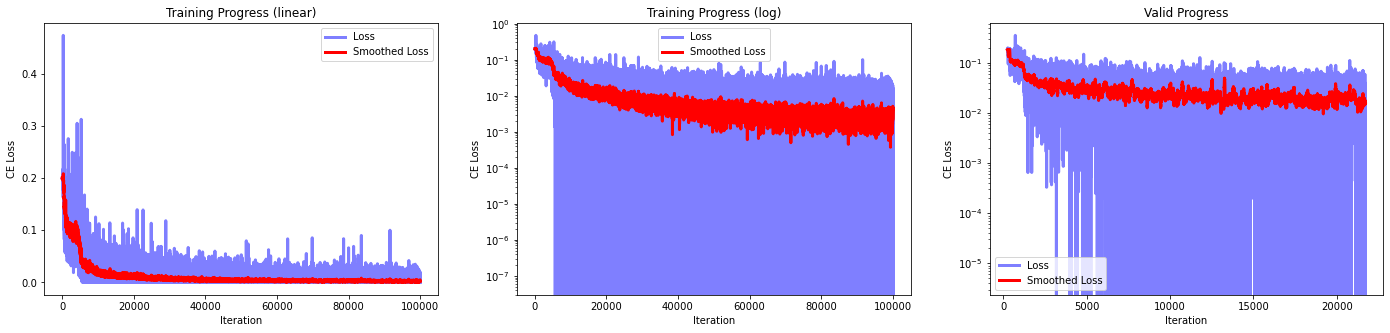

In [14]:
visualize_progress(trainer.train_loss, trainer.valid_loss, start=120)

In [16]:
stats = {
    "train_loss": trainer.train_loss,
    "valid_loss": trainer.valid_loss
}
save_model(trainer.model, trainer.optimizer, trainer.iter_, stats)

In [ ]:
git 